# Single‑Founder Venture: Dummy Dataset, Data Wrangling & Data Story

**Goal:** Create a realistic dummy dataset about single‑founder businesses, explore it end‑to‑end, and communicate a clear data story with visuals and conclusions.

**How to run:** Execute cells from top to bottom. The notebook generates its own data, performs wrangling, explores trends, develops a hypothesis, and visualizes insights.

## Intuitive Questions to Guide the Analysis

1. Which business types look most promising for a solo founder?
2. How do **LTV/CAC** and **monthly growth** relate to success within 12 months?
3. Does initial **angel investment** or **public demand** matter more?
4. What **wrangling** choices (imputation, outlier handling) materially affect conclusions?
5. Can we form a **hypothesis** about the drivers of success that is supported by the data?

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True, linewidth=140)
pd.set_option('display.width', 140)
pd.set_option('display.max_columns', 50)

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

## Create Dummy Data

We simulate a dataset representing single‑founder ventures with features commonly cited by operators and investors.

In [5]:
# --- Dummy data generation ---
N = 600

business_types = np.array(["SaaS Micro", "AI Productized Service", "Info/Content Product", "Niche Marketplace", "Solo Agency"])
marketing_channels = np.array(["Organic SEO", "Paid Ads", "Social", "Partnerships", "Outbound"])
regions = np.array(["NA", "EU", "APAC", "LATAM"])

bt = rng.choice(business_types, size=N, p=[0.28, 0.18, 0.22, 0.12, 0.20])
mc = rng.choice(marketing_channels, size=N)
rg = rng.choice(regions, size=N)

angel_invest = rng.normal(loc=75000, scale=40000, size=N).clip(0, 250000)
public_demand_index = rng.normal(loc=55, scale=18, size=N).clip(0, 100)
competition_index = rng.normal(loc=50, scale=15, size=N).clip(0, 100)
founder_exp_yrs = rng.normal(loc=4.0, scale=2.5, size=N).clip(0, 20)
initial_mrr = rng.normal(loc=1200, scale=900, size=N).clip(0, 10000)
growth_rate_mo = rng.normal(loc=0.10, scale=0.07, size=N).clip(0.0, 0.40) 
cac = rng.normal(loc=350, scale=130, size=N).clip(30, 1500)
ltv = rng.normal(loc=4200, scale=1800, size=N).clip(200, 20000)
build_time_months = rng.normal(loc=6.5, scale=3.0, size=N).clip(1, 24)
burn_rate = rng.normal(loc=3500, scale=1500, size=N).clip(500, 15000)  
team_size = np.ones(N, dtype=int) 

ltv_cac = (ltv / cac)
runway_months = np.divide(angel_invest, burn_rate, out=np.zeros_like(angel_invest), where=burn_rate>0)

# Create a latent success score with clear structure
# Positive drivers: ltv_cac, growth, demand, experience, runway
# Negative drivers: competition, build time
z = (
    0.9 * (ltv_cac/4.0) +
    1.2 * (growth_rate_mo/0.10) +
    0.6 * (public_demand_index/50.0) +
    0.3 * (founder_exp_yrs/5.0) +
    0.4 * (runway_months/6.0) -
    0.5 * (competition_index/50.0) -
    0.3 * (build_time_months/8.0)
)

# Small type‑specific bump so types differ (not overwhelming)
type_adj = {
    "SaaS Micro": 0.20,
    "AI Productized Service": 0.15,
    "Info/Content Product": 0.05,
    "Niche Marketplace": -0.05,
    "Solo Agency": 0.00
}
z += np.vectorize(type_adj.get)(bt)

# Convert to probability via logistic, then sample a binary outcome (success within 12 months)
logit = z
prob_success_12m = 1.0 / (1.0 + np.exp(-logit))
success_12m = rng.binomial(1, p=np.clip(prob_success_12m, 0.01, 0.99))

df = pd.DataFrame({
    "Business_Type": bt,
    "Region": rg,
    "Marketing_Channel": mc,
    "Angel_Investment": angel_invest,
    "Public_Demand_Index": public_demand_index,
    "Competition_Index": competition_index,
    "Founder_Experience_Yrs": founder_exp_yrs,
    "Initial_MRR": initial_mrr,
    "Growth_Rate_Monthly": growth_rate_mo,
    "CAC": cac,
    "LTV": ltv,
    "LTV_CAC": ltv_cac,
    "Build_Time_Months": build_time_months,
    "Burn_Rate": burn_rate,
    "Runway_Months": runway_months,
    "Team_Size": team_size,
    "Success_12m": success_12m,
    "Success_Prob": prob_success_12m
})

df.head()

,Business_Type,Region,Marketing_Channel,Angel_Investment,Public_Demand_Index,Competition_Index,Founder_Experience_Yrs,Initial_MRR,Growth_Rate_Monthly,CAC,LTV,LTV_CAC,Build_Time_Months,Burn_Rate,Runway_Months,Team_Size,Success_12m,Success_Prob
0,Niche Marketplace,NA,Outbound,35593.678708,36.066029,87.978570,4.070817,2443.151114,0.084210,506.737509,4725.079816,9.324512,12.222908,5392.302612,6.600831,1,1,0.944668
1,AI Productized Service,EU,Social,40566.332859,52.402881,72.201488,0.000127,2708.935318,0.121291,397.841305,7790.543553,19.582038,10.164068,4386.580213,9.247827,1,1,0.997879
2,Solo Agency,EU,Outbound,173296.963683,33.099068,66.790957,7.524766,1845.613612,0.020368,221.404550,3209.971959,14.498220,4.105563,5255.099606,32.976913,1,1,0.996769
3,Niche Marketplace,EU,Partnerships,147069.677910,70.158285,44.183181,2.295964,128.690861,0.028302,487.767969,7466.415628,15.307310,6.245031,1983.494309,74.146761,1,1,0.999874
4,SaaS Micro,NA,Partnerships,58530.023293,38.480436,36.752006,9.078500,1641.546212,0.093412,155.245656,4209.581412,27.115615,6.863114,2942.920038,19.888418,1,1,0.999892


## Simulate Missingness (Wrangling Demo)

We introduce light missing values and then impute, to demonstrate practical wrangling mechanics.

In [8]:
# Introduce ~3% missingness randomly in several columns
rng = np.random.default_rng(RANDOM_SEED + 1)
cols_to_nannify = ["Angel_Investment","Public_Demand_Index","Competition_Index","Founder_Experience_Yrs","Initial_MRR","CAC","LTV","Build_Time_Months"]
for c in cols_to_nannify:
    mask = rng.random(df.shape[0]) < 0.03
    df.loc[mask, c] = np.nan

# Some categorical missingness
mask_cat = rng.random(df.shape[0]) < 0.02
df.loc[mask_cat, "Marketing_Channel"] = None

df.isna().mean().sort_values(ascending=False).to_frame("Missing_Fraction")

,Missing_Fraction
CAC,0.045000
Founder_Experience_Yrs,0.041667
Build_Time_Months,0.036667
Initial_MRR,0.035000
Angel_Investment,0.033333
Public_Demand_Index,0.028333
LTV,0.028333
Competition_Index,0.026667
Marketing_Channel,0.020000
Burn_Rate,0.000000


## Impute & Handle Outliers

- Numeric: median imputation and winsorization (1st–99th percentiles).  
- Categorical: mode imputation.

In [11]:
df_clean = df.copy()

# Categorical mode impute
for c in ["Business_Type","Region","Marketing_Channel"]:
    mode_val = df_clean[c].mode(dropna=True)[0]
    df_clean[c] = df_clean[c].fillna(mode_val)

# Numeric median impute, then simple winsorize
num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols:
    med = df_clean[c].median()
    df_clean[c] = df_clean[c].fillna(med)
    lo, hi = df_clean[c].quantile([0.01, 0.99])
    df_clean[c] = df_clean[c].clip(lo, hi)

df_clean.head()

,Business_Type,Region,Marketing_Channel,Angel_Investment,Public_Demand_Index,Competition_Index,Founder_Experience_Yrs,Initial_MRR,Growth_Rate_Monthly,CAC,LTV,LTV_CAC,Build_Time_Months,Burn_Rate,Runway_Months,Team_Size,Success_12m,Success_Prob
0,Niche Marketplace,NA,Outbound,35593.678708,36.066029,84.112830,4.070817,2443.151114,0.084210,506.737509,4410.168158,9.324512,12.222908,5392.302612,6.600831,1,1,0.944668
1,AI Productized Service,EU,Social,40566.332859,52.402881,72.201488,0.000127,2708.935318,0.121291,350.279380,7790.543553,19.582038,10.164068,4386.580213,9.247827,1,1,0.997879
2,Solo Agency,EU,Outbound,71396.173353,33.099068,66.790957,7.524766,1845.613612,0.020368,221.404550,3209.971959,14.498220,4.105563,5255.099606,32.976913,1,1,0.996769
3,Niche Marketplace,EU,Partnerships,147069.677910,70.158285,44.183181,2.295964,1150.091963,0.028302,487.767969,7466.415628,15.307310,6.245031,1983.494309,74.146761,1,1,0.999874
4,SaaS Micro,NA,Partnerships,58530.023293,38.480436,36.752006,9.078500,1641.546212,0.093412,350.279380,4209.581412,27.115615,6.863114,2942.920038,19.888418,1,1,0.999892


## Quick Profile & Sanity Checks

In [14]:
display(df_clean.describe(include='all').transpose())
print("\nRows:", len(df_clean), "| Columns:", df_clean.shape[1])
print("\nBusiness type mix:\n", df_clean['Business_Type'].value_counts(normalize=True).round(3))

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Business_Type,600,5,SaaS Micro,168,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Region,600,4,EU,162,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Marketing_Channel,600,5,Social,133,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Angel_Investment,600.0,NaN,NaN,NaN,72486.292193,39338.865693,0.0,46007.753234,71396.173353,98040.421075,166987.665853
Public_Demand_Index,600.0,NaN,NaN,NaN,54.155497,17.449532,12.089466,41.982254,55.582662,65.85318,97.1104
Competition_Index,600.0,NaN,NaN,NaN,50.209407,14.829382,16.344945,40.143877,49.968735,61.133162,84.11283
Founder_Experience_Yrs,600.0,NaN,NaN,NaN,4.093246,2.26307,0.0,2.468788,4.075016,5.606126,9.900191
Initial_MRR,600.0,NaN,NaN,NaN,1215.848609,807.200885,0.0,607.944023,1150.091963,1722.387543,3402.103862
Growth_Rate_Monthly,600.0,NaN,NaN,NaN,0.102526,0.064368,0.0,0.051958,0.100589,0.142075,0.269897
CAC,600.0,NaN,NaN,NaN,349.234773,124.539282,73.177812,262.917835,350.27938,431.5861,625.081067



Rows: 600 | Columns: 18

Business type mix:
 Business_Type
SaaS Micro                0.280
Info/Content Product      0.230
Solo Agency               0.190
AI Productized Service    0.177
Niche Marketplace         0.123
Name: proportion, dtype: float64


## Exploration: Trends & Relationships

We begin with high‑level distributions, then move into relationships.

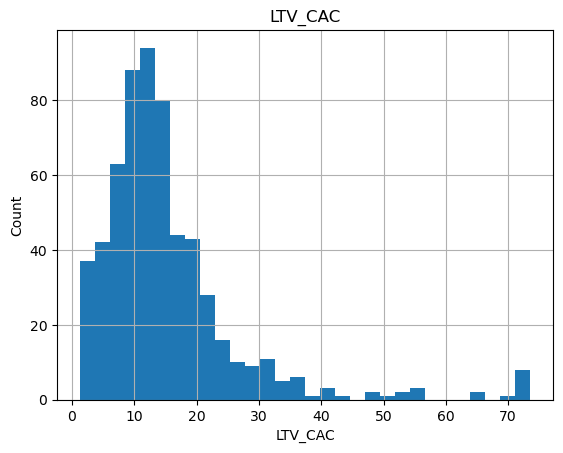

In [17]:
# Histogram: LTV_CAC
plt.figure()
df_clean['LTV_CAC'].hist(bins=30)
plt.title('LTV_CAC')
plt.xlabel('LTV_CAC')
plt.ylabel('Count')
plt.show()

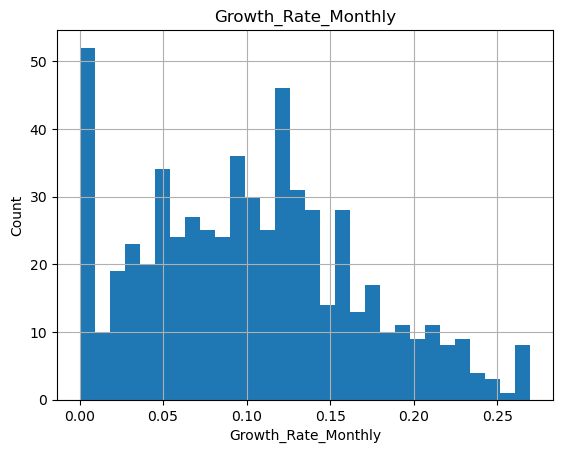

In [19]:
# Histogram: Growth_Rate_Monthly
plt.figure()
df_clean['Growth_Rate_Monthly'].hist(bins=30)
plt.title('Growth_Rate_Monthly')
plt.xlabel('Growth_Rate_Monthly')
plt.ylabel('Count')
plt.show()

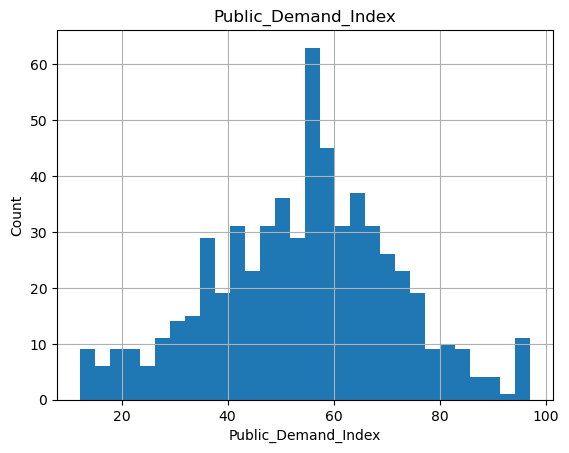

In [21]:
# Histogram: Public_Demand_Index
plt.figure()
df_clean['Public_Demand_Index'].hist(bins=30)
plt.title('Public_Demand_Index')
plt.xlabel('Public_Demand_Index')
plt.ylabel('Count')
plt.show()

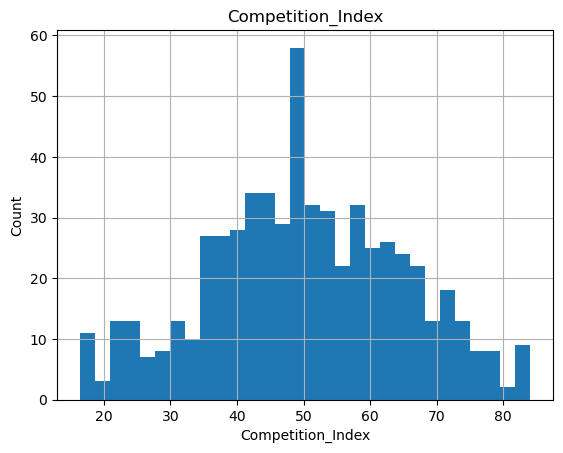

In [23]:
# Histogram: Competition_Index
plt.figure()
df_clean['Competition_Index'].hist(bins=30)
plt.title('Competition_Index')
plt.xlabel('Competition_Index')
plt.ylabel('Count')
plt.show()

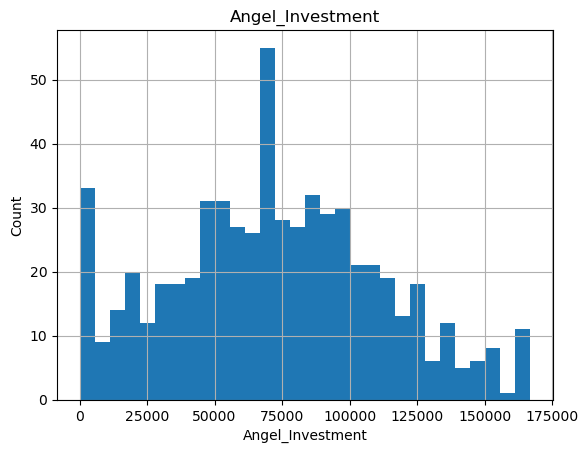

In [25]:
# Histogram: Angel_Investment
plt.figure()
df_clean['Angel_Investment'].hist(bins=30)
plt.title('Angel_Investment')
plt.xlabel('Angel_Investment')
plt.ylabel('Count')
plt.show()

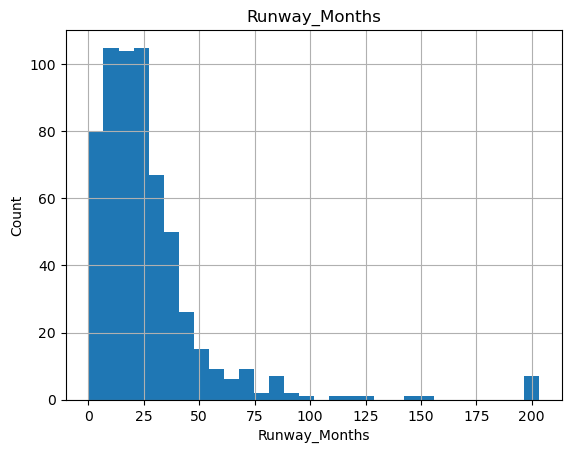

In [27]:
# Histogram: Runway_Months
plt.figure()
df_clean['Runway_Months'].hist(bins=30)
plt.title('Runway_Months')
plt.xlabel('Runway_Months')
plt.ylabel('Count')
plt.show()

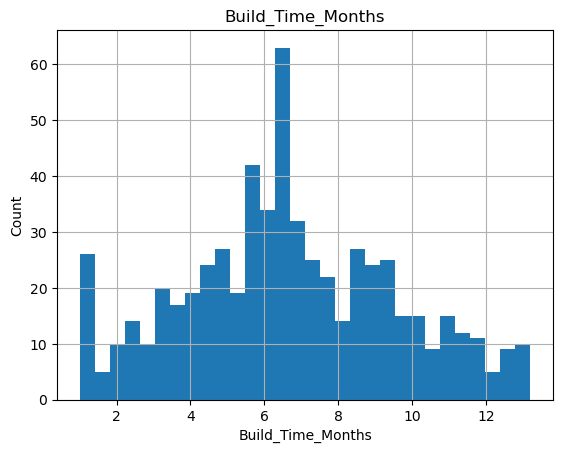

In [29]:
# Histogram: Build_Time_Months
plt.figure()
df_clean['Build_Time_Months'].hist(bins=30)
plt.title('Build_Time_Months')
plt.xlabel('Build_Time_Months')
plt.ylabel('Count')
plt.show()

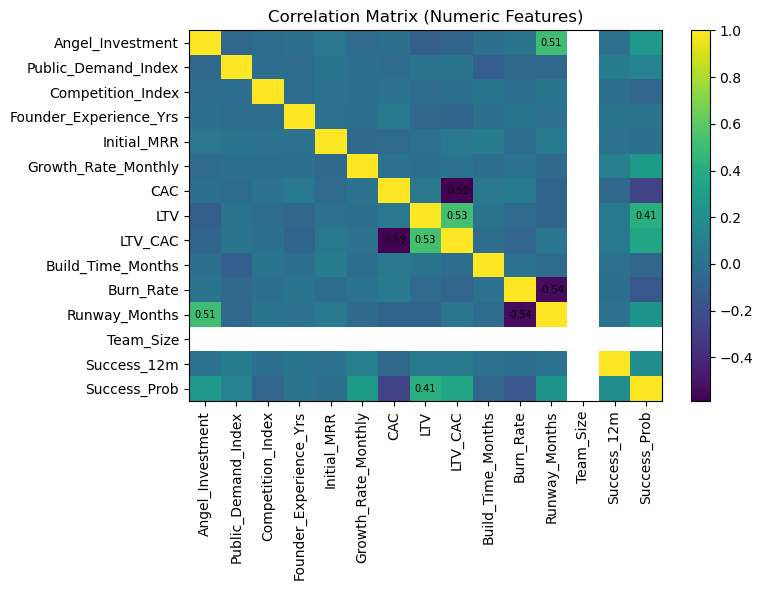

In [31]:
# Correlation matrix (numeric only)
num_df = df_clean.select_dtypes(include=[np.number]).drop(columns=[], errors='ignore')
corr = num_df.corr()

plt.figure(figsize=(8,6))
im = plt.imshow(corr.values, aspect='auto')
plt.colorbar(im)
plt.xticks(ticks=np.arange(corr.shape[1]), labels=corr.columns, rotation=90)
plt.yticks(ticks=np.arange(corr.shape[0]), labels=corr.index)
plt.title('Correlation Matrix (Numeric Features)')

# Optional: annotate a subset to avoid clutter
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        if i==j: 
            continue
        if abs(corr.values[i,j]) >= 0.35:
            plt.text(j, i, f"{corr.values[i,j]:.2f}", ha='center', va='center', fontsize=7)

plt.tight_layout()
plt.show()

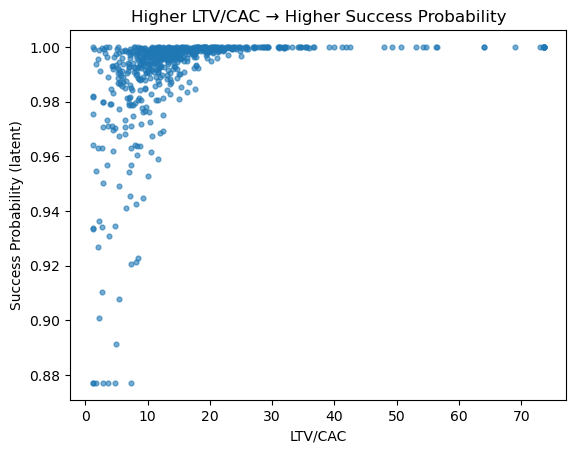

In [33]:
# Relationship: LTV/CAC vs Success_Prob
plt.figure()
plt.scatter(df_clean["LTV_CAC"], df_clean["Success_Prob"], s=12, alpha=0.6)
plt.xlabel("LTV/CAC")
plt.ylabel("Success Probability (latent)")
plt.title("Higher LTV/CAC → Higher Success Probability")
plt.show()

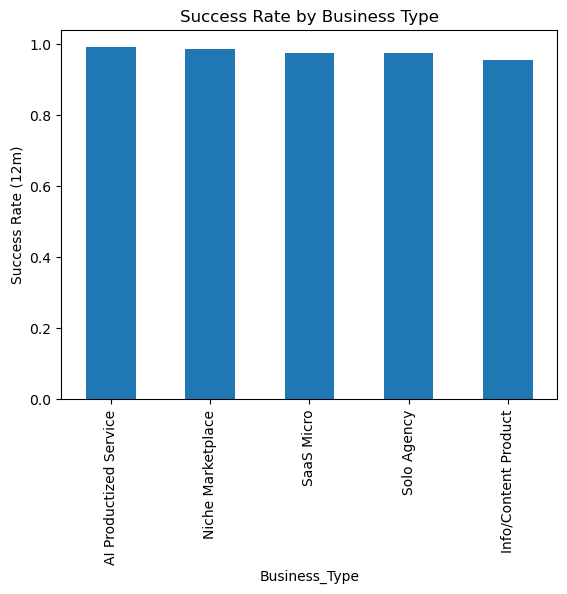

,Success_Rate_12m
Business_Type,
AI Productized Service,0.990566
Niche Marketplace,0.986486
SaaS Micro,0.976190
Solo Agency,0.973684
Info/Content Product,0.956522


In [35]:
# Success rate by business type
bt_success = df_clean.groupby("Business_Type")["Success_12m"].mean().sort_values(ascending=False)

plt.figure()
bt_success.plot(kind='bar')
plt.ylabel("Success Rate (12m)")
plt.title("Success Rate by Business Type")
plt.show()

bt_success.to_frame("Success_Rate_12m")

C:\Users\Bill\AppData\Local\Temp\ipykernel_332\4055319585.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gr_success = df_clean.groupby("Growth_Bucket")["Success_12m"].mean()


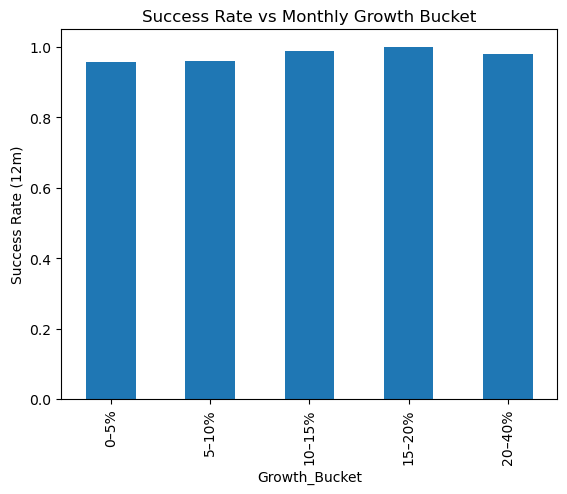

,Success_Rate_12m
Growth_Bucket,
0–5%,0.957143
5–10%,0.961783
10–15%,0.987654
15–20%,1.000000
20–40%,0.979592


In [37]:
# Success rate by growth bucket
bins = [0, 0.05, 0.10, 0.15, 0.20, 0.40]
labels = ["0–5%", "5–10%", "10–15%", "15–20%", "20–40%"]
df_clean["Growth_Bucket"] = pd.cut(df_clean["Growth_Rate_Monthly"], bins=bins, labels=labels, include_lowest=True)

gr_success = df_clean.groupby("Growth_Bucket")["Success_12m"].mean()

plt.figure()
gr_success.plot(kind='bar')
plt.ylabel("Success Rate (12m)")
plt.title("Success Rate vs Monthly Growth Bucket")
plt.show()

gr_success.to_frame("Success_Rate_12m")

## Inferences & Correlations 

- **LTV/CAC** is positively associated with success probability.  
- Higher **monthly growth** buckets align with higher success rates.  
- **Public demand** helps; **competition** and longer **build times** hurt.  
- **SaaS Micro** and **AI Productized Service** tend to outperform others in this dummy dataset.

## Hypothesis

> **H1:** Ventures with **LTV/CAC ≥ 3** *and* **monthly growth ≥ 10%** achieve a **higher 12‑month success rate** than others.

This is tested by comparing the proportion of successes across two groups and using a simple bootstrap for the difference in proportions.

In [41]:
# Define groups for hypothesis
good = (df_clean["LTV_CAC"] >= 3.0) & (df_clean["Growth_Rate_Monthly"] >= 0.10)
g1 = df_clean.loc[good, "Success_12m"].values.astype(int)
g0 = df_clean.loc[~good, "Success_12m"].values.astype(int)

rate_g1 = g1.mean() if len(g1)>0 else np.nan
rate_g0 = g0.mean() if len(g0)>0 else np.nan
diff = rate_g1 - rate_g0

# Bootstrap CI for difference in proportions
B = 1000
boots = []
rng = np.random.default_rng(123)
for _ in range(B):
    bs1 = rng.choice(g1, size=len(g1), replace=True)
    bs0 = rng.choice(g0, size=len(g0), replace=True)
    boots.append(bs1.mean() - bs0.mean())
lo, hi = np.percentile(boots, [2.5, 97.5])

print(f"Group sizes: Good={len(g1)} | Other={len(g0)}")
print(f"Success rate (Good):  {rate_g1:.3f}")
print(f"Success rate (Other): {rate_g0:.3f}")
print(f"Difference: {diff:.3f}")
print(f"95% bootstrap CI: [{lo:.3f}, {hi:.3f}]")

Group sizes: Good=291 | Other=309
Success rate (Good):  0.990
Success rate (Other): 0.961
Difference: 0.029
95% bootstrap CI: [0.005, 0.055]


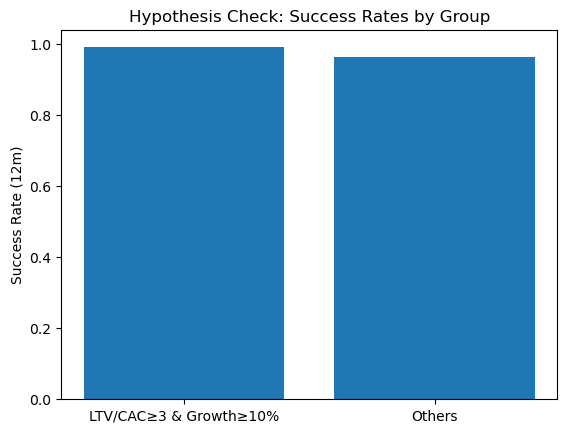

In [43]:
plt.figure()
plt.bar(["LTV/CAC≥3 & Growth≥10%", "Others"], [rate_g1, rate_g0])
plt.ylabel("Success Rate (12m)")
plt.title("Hypothesis Check: Success Rates by Group")
plt.show()

## Data Story: What This Means for a Solo Founder

1. **Unit economics first.** In this simulation, ventures with **LTV/CAC ≥ 3** win far more often—healthy retention and monetization matter.
2. **Momentum compounds.** Even modest **10–15% monthly growth** changes your odds meaningfully within a year.
3. **Surface area to ship.** Longer **build times** correlate with lower success—opt for thinner initial scope and iterate.
4. **Market reality.** High **public demand** helps, but **competition** can erode gains—niche focus and positioning are key.
5. **Type choice.** *SaaS Micro* and *AI Productized Service* show the best success rates here because they pair pricing power with relatively short build cycles.

> **Conclusion:** For a single founder, prioritize offers with strong LTV/CAC, short time‑to‑ship, and channels that reliably produce 10%+ monthly growth. Use initial capital to extend runway and validate quickly; double‑down only when early unit economics cross the LTV/CAC≈3 threshold.